In [1]:
!pip install --quiet gdown


file_id = "1CSkQOyYbQ0aHf67ETLJ58Gp5RlnPkSxZ"
url = f"https://drive.google.com/uc?id={file_id}"

!gdown --quiet $url -O si.lammps-dump-text

file_id = "1JCFXgqru7S-DCJIZO2Xvar87Tdgfx3qZ"
url = f"https://drive.google.com/uc?id={file_id}"

!gdown --quiet $url -O si_solid.lammps-dump-text

In [3]:
!pip install ase numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from ase.io.lammpsrun import read_lammps_dump
from ase.geometry.analysis import Analysis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.9 MB/s eta 0:00:00


In [7]:
# ----------- Parameters -----------
file_liquid = "si.lammps-dump-text"
file_solid  = "si_solid.lammps-dump-text"

n_frames = 500              # use last 500 frames
time_step_fs = 100          # 100 fs per frame
bins = np.arange(5, 51, 5)  # bin sizes: 5, 10, ..., 50 frames (0.5 ps to 5 ps)

In [10]:
# ----------- Helper: unwrap PBC for ASE trajectory -----------
def compute_msd_safely(frames, bins, time_step_fs):

    positions = np.array([atoms.positions for atoms in frames])  # (n_frames, n_atoms, 3)
    cell = frames[0].get_cell()  # assume cubic or orthorhombic box
    box_lengths = np.diag(cell)  # (3,)
    half_box = box_lengths / 2.0

    n_frames, n_atoms, _ = positions.shape
    msd_vals = []
    times_fs = []

    for dt in bins:
        displacements = positions[dt:] - positions[:-dt]  # shape: (n_frames - dt, n_atoms, 3)


        mask = np.all(np.abs(displacements) < half_box, axis=2)  # shape: (n_frames - dt, n_atoms)


        sq_disp = np.sum(displacements ** 2, axis=2)  # (frames - dt, atoms)
        valid_disp = np.where(mask, sq_disp, np.nan)


        msd_dt = np.nanmean(valid_disp)
        msd_vals.append(msd_dt)
        times_fs.append(dt * time_step_fs)

    return np.array(times_fs), np.array(msd_vals)

In [12]:
# ----------- Load last 500 frames -----------
frames_liquid = read_lammps_dump(file_liquid, index=slice(-n_frames, None))
frames_solid  = read_lammps_dump(file_solid, index=slice(-n_frames, None))

# ----------- Compute MSD -----------
times_liq, msd_liq = compute_msd_safely(frames_liquid, bins, time_step_fs)
times_sol, msd_sol = compute_msd_safely(frames_solid,  bins, time_step_fs)

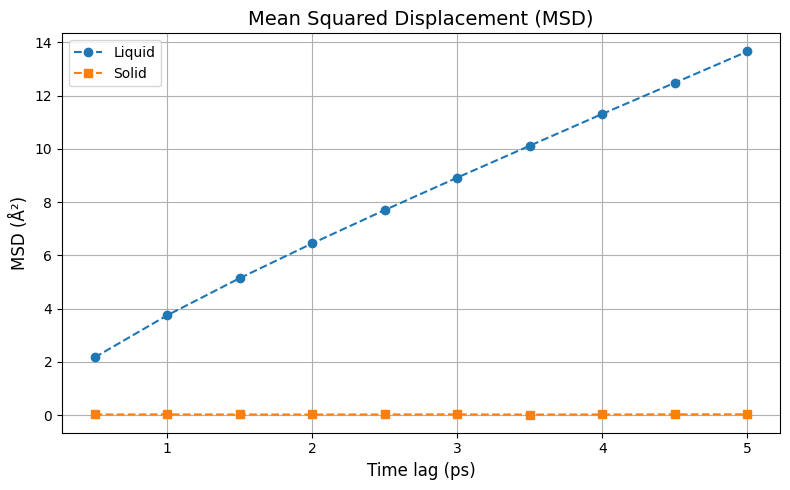

In [13]:
# ----------- Plot MSD -----------

plt.figure(figsize=(8, 5))
plt.plot(times_liq / 1000, msd_liq, 'o--', label='Liquid')  # time in ps
plt.plot(times_sol / 1000, msd_sol, 's--', label='Solid')
plt.xlabel("Time lag (ps)", fontsize=12)
plt.ylabel("MSD (Å²)", fontsize=12)
plt.title("Mean Squared Displacement (MSD)", fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("msd_comparison.png")
plt.show()